# Proactive Interference Branch


In [1]:
from glob import glob as glob
import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
task = PurePM(ntokens=3,stimdim=1,seed=np.random.randint(300))
tseq,xseq,yseq = task.gen_ep_data(ntrials=2,ppt=4,switchmaps=True)
print(xseq.reshape(2,-1))
print('inst')
print(tseq.reshape(2,-1))
print('y')
print(yseq.reshape(2,-1))


tensor([[0.9097, 0.3557, 0.0482, 0.9097, 0.0482, 0.0482, 0.9097],
        [0.0482, 0.9097, 0.3557, 0.9097, 0.3557, 0.3557, 0.0482]])
inst
tensor([[0, 1, 2, 0, 0, 0, 0],
        [1, 0, 2, 0, 0, 0, 0]])
y
tensor([[0, 1, 2, 0, 2, 2, 0],
        [1, 0, 2, 0, 2, 2, 1]])


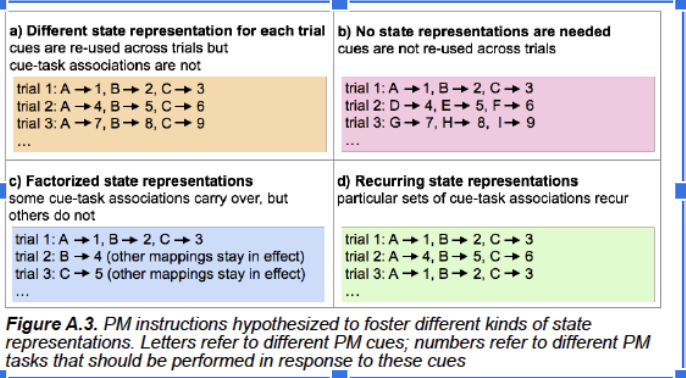

# todo
- eval on sequence with two trials
- write exam function
    - used to decide when to randomize matrix
    - evaluates model on sequences of all lengths

In [61]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)
                           
def train_model(net,task,neps,ntrials=2,seqlen=10):
  """ 
  variable sequence length training
  closed loop randomizing of embedding
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  acc = -np.ones(neps)
  for ep in range(neps):
    # forward prop
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen=seqlen,switchmaps=False)
    yhat_ulog = net(tseq,xseq)
    # eval
    trial_acc = np.mean((maxsoftmax(yhat_ulog) == ytarget).numpy())
    acc[ep] = trial_acc
    # backprop
    for tstep in range(len(tseq)):
      # only backprop response trials
#       if tseq[tstep] == 0:
      optiop.zero_grad()
      loss = lossop(yhat_ulog[tstep],ytarget[tstep])
      loss.backward(retain_graph=True)
      optiop.step()
    if trial_acc>=.99:
      task.randomize_emat()
  return acc

def eval_model(net,task,neps,seqlen=4,ntrials=1):
  """ 
  fixed sequence length eval
  new embedding for every episode
  """
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
#   print('not randomizing')
  for ep in range(neps):
    task.randomize_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def mov_avg(arr,wind):
  X = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    X[t] = np.mean(arr[t:t+wind])
  return X

In [62]:
sd = 1
sdim = 10
ntokens = 2

task = PurePM(
        ntokens=ntokens,
        stimdim=sdim,
        seed=sd
)

net = PINet(
        stimdim=sdim,
        stsize=25,
        outdim=ntokens,
        ninstructs=ntokens+1,
        seed=sd
)

In [68]:
neps_tr = 10000
tr_acc = train_model(net,task,neps_tr,ntrials=2,seqlen=3)


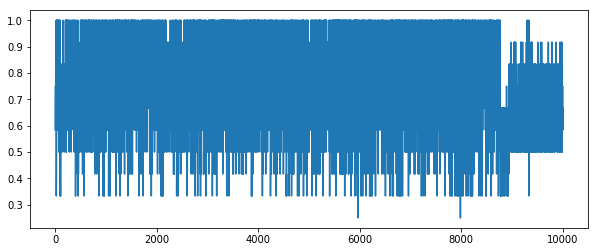

In [78]:
plt.figure(figsize=(10,4))
plt.plot(mov_avg(tr_acc,1))

not randomizing


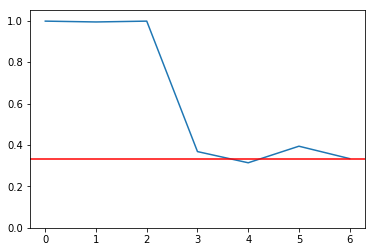

In [76]:
neps_ev = 500
ev_score = eval_model(net,task,neps_ev)
plt.plot(ev_score.mean(0))
plt.ylim(0,1.05)
plt.axhline(.33,c='r')

# debug

In [9]:
task2 = PMTask_PI(
        nback=0,
        ntokens_pm=1,
        ntokens_og=3,
        stimdim=sdim,
        seed=np.random.randint(3000)
)

trial_len=[3,6]
ntrials=2
tseq,xseq,ytarget = task2.gen_ep_data(trial_len[0],trial_len[1],ntrials)
tseq
xseq
ytarget
ytarget
xseq,ytarget

(tensor([[[0.6518, 0.3425, 0.9352, 0.3451, 0.5561, 0.0405, 0.5620, 0.5015,
           0.9624, 0.0759]],
 
         [[0.1719, 0.8870, 0.5752, 0.0701, 0.5685, 0.1652, 0.0370, 0.5273,
           0.7221, 0.3830]],
 
         [[0.0363, 0.0136, 0.0660, 0.3173, 0.0419, 0.3405, 0.1029, 0.1626,
           0.6719, 0.0655]],
 
         [[0.0363, 0.0136, 0.0660, 0.3173, 0.0419, 0.3405, 0.1029, 0.1626,
           0.6719, 0.0655]],
 
         [[0.6518, 0.3425, 0.9352, 0.3451, 0.5561, 0.0405, 0.5620, 0.5015,
           0.9624, 0.0759]],
 
         [[0.6518, 0.3425, 0.9352, 0.3451, 0.5561, 0.0405, 0.5620, 0.5015,
           0.9624, 0.0759]],
 
         [[0.1719, 0.8870, 0.5752, 0.0701, 0.5685, 0.1652, 0.0370, 0.5273,
           0.7221, 0.3830]],
 
         [[0.7877, 0.4098, 0.6916, 0.3457, 0.6337, 0.6058, 0.8785, 0.8699,
           0.8837, 0.2707]],
 
         [[0.1719, 0.8870, 0.5752, 0.0701, 0.5685, 0.1652, 0.0370, 0.5273,
           0.7221, 0.3830]],
 
         [[0.7877, 0.4098, 0.6916, 0.3457, 0.6